In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from google.colab.data_table import DataTable
DataTable.max_columns = 200

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
'''
MSP is the fully connected network. It takes the embedding from vgg-16 + 
a screen context vector and learns to map onto reward or no reward.
'''

class MSP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MSP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # first hidden layer with 100 neurons
        self.fc2 = nn.Linear(hidden_size, 1)  # second (output) layer with 1 neuron for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = (self.fc2(x)) #torch.relu torch.sigmoid
        return x


    def predict_hidden(self, x):
        x = torch.relu(self.fc1(x)) #F.sigmoid
        # x = (self.ca1(x)) #F.sigmoid
        return x

class MyDataset(Dataset):
    def __init__(self, csv_path, labels):
        self.data = torch.tensor(pd.read_csv(csv_path, delimiter=',').values)
        self.labels = torch.tensor(labels)
        print(f"Data shape: {self.data.shape}, Labels shape: {self.labels.shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# display(enumerate(trainloader, 0))
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.uniform_(m.weight, a=-0.015,b=0.015)
#         # torch.nn.init.normal_(m.weight, mean=-1, std=1.0)
#         # m.bias.data.fill_(0.01)


In [ ]:
## Setting Parameters

# Model
learning_rate = 0.001
num_epochs = 1000
num_runs = 30

# Stats
exp1_n = 32
exp2_n = 32
exp3_n = 64

# Training/testing sets
phy = '2'

if phy == '2':
  exp1_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/train_vgg-16_embeddings.csv'
  exp2_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/train_vgg-16_embeddings_generalization.csv'
  exp3_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/train_vgg-16_embeddings_probe.csv'
elif phy == '3':
  exp1_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/phy3_train_vgg-16_embeddings.csv'
  exp2_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/phy3_train_vgg-16_embeddings_generalization.csv'
  exp3_dir = '/content/drive/MyDrive/rhesus_category_learning_model/embeddings_resnet50/phy3_train_vgg-16_embeddings_probe.csv'

# Output tags
dirtag = "/content/drive/MyDrive/rhesus_category_learning_model/Learning NN/output_plots/vgg-16_msp_lr" + str(learning_rate) + '_phy' + phy + "/"

In [ ]:
## Setting up dataloaders

labels = np.concatenate([np.repeat(1,4), np.repeat(0,16), np.repeat(1,4), np.repeat(0,8)]).reshape(32,1)
rewarded_labels = np.zeros(32)
rewarded_labels[2::4] = 1
rewarded_labels = np.concatenate([rewarded_labels, np.zeros(64), rewarded_labels]).reshape(128,1)

# create dataset and dataloader
dataset = MyDataset(exp1_dir, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# create test dataset and dataloader
test_dataset = MyDataset(exp2_dir, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# create probe dataset and dataloader
probe_labels = np.zeros(32)
probe_labels[2::4] = 1
probe_labels = np.concatenate([probe_labels, np.zeros(64), probe_labels]).reshape(128,1)
probe_dataset = MyDataset(exp3_dir, probe_labels)
probe_dataloader = DataLoader(probe_dataset, batch_size=128)

Data shape: torch.Size([32, 4196]), Labels shape: torch.Size([32, 1])
Data shape: torch.Size([32, 4196]), Labels shape: torch.Size([32, 1])
Data shape: torch.Size([128, 4196]), Labels shape: torch.Size([128, 1])


In [ ]:
## Performance masks

probe_loss_labels = np.tile(np.arange(4), 8) # NE = 0; SOE = 1; SP = 2; Distractor = 3
probe_loss_labels = np.concatenate([probe_loss_labels, np.zeros(64),probe_loss_labels]).reshape(128,1)

In [ ]:
## NOTE: Some of the indentations (loop appends) dont work for multiple batches per epoch. 
## We need to stick to train and test batches of 32, and probe batches of 128

train_performance = np.array([])
train_losses = np.array([])
test_performance = np.array([])
test_losses = np.array([])
probe_performance = np.array([])
probe_losses = np.array([])

train_loss_rewarded = np.array([])
train_loss_unrewarded = np.array([])

test_loss_rewarded = np.array([])
test_loss_unrewarded = np.array([])

probe_loss_rewarded = np.array([])
probe_loss_unrewarded = np.array([])

probe_loss_NE = np.array([])
probe_loss_SOE = np.array([])
probe_loss_distractor = np.array([])

probe_loss_SP_over_SOE_performance = np.array([])

hidden_acts = np.array([])

for i in range(num_runs):

  model = MSP()

  # flat_list = [item for sublist in model.fc1.weight.detach().numpy() for item in sublist]
  # plt.hist(flat_list)
  # # print(net.ca1.weight)#.detach().numpy().squeeze().squeeze())
  # plt.show()

  # model.apply(init_weights)

  # flat_list = [item for sublist in model.fc1.weight.detach().numpy() for item in sublist]
  # plt.hist(flat_list)
  # # print(net.ca1.weight)#.detach().numpy().squeeze().squeeze())
  # plt.show()

  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate) #0.0005

  with torch.no_grad():

    for batch, label in dataloader:
      # display(batch.shape, label)
      data = batch.float()
      output = model.predict_hidden(data)
      hidden_acts = np.append(hidden_acts, output.cpu().detach().numpy())

    for batch, label in dataloader:
      data = batch.float() # cast input data to float
      target = label.float() # cast target labels to float
      output = model(data)
      loss = criterion(output, target)
      predicted = (output > 0.5).float()

    train_performance = np.append(train_performance, (predicted == target).sum().item() * 100 / exp1_n)
    train_losses = np.append(train_losses, loss.item())

    # display(label == True)
    train_loss_rewarded = np.append(train_loss_rewarded, criterion(output[target == True], target[target == True]) )
    train_loss_unrewarded = np.append(train_loss_unrewarded, criterion(output[target == False], target[target == False]))

    for data, labels in test_dataloader:
      data = data.float()
      labels = labels.float()
      outputs = model(data)
      predicted = (outputs > 0.5).float()
    test_performance = np.append(test_performance, (predicted == labels).sum().item() * 100 / exp1_n)
    test_losses = np.append(test_losses, criterion(outputs,labels).item())
    
    test_loss_rewarded = np.append(test_loss_rewarded, criterion(outputs[labels == True], labels[labels == True]) )
    test_loss_unrewarded = np.append(test_loss_unrewarded, criterion(outputs[labels == False], labels[labels == False]))
    
   
    for data, labels in probe_dataloader:
      data = data.float()
      labels = labels.float()
      outputs = model(data)
      predicted = (outputs > 0.5).float()

    probe_performance = np.append(probe_performance, (predicted == labels).sum().item() * 100 / 128)
    probe_losses = np.append(probe_losses, criterion(outputs,labels).item())
    
    # display(((predicted == labels)[96:][2::4]))
    probe_loss_rewarded = np.append(probe_loss_rewarded, criterion(outputs[labels == True], labels[labels == True]))
    probe_loss_unrewarded = np.append(probe_loss_unrewarded, criterion(outputs[labels == False], labels[labels == False]))

    probe_loss_NE = np.append(probe_loss_NE, criterion(outputs[probe_loss_labels == 0], labels[probe_loss_labels == 0]))
    probe_loss_SOE = np.append(probe_loss_SOE, criterion(outputs[probe_loss_labels == 1], labels[probe_loss_labels == 1]))
    probe_loss_distractor = np.append(probe_loss_distractor, criterion(outputs[probe_loss_labels == 2], labels[probe_loss_labels == 2]))

    # probe_loss_SP_over_SOE_performance =  np.append(probe_loss_SP_over_SOE_performance, (outputs[labels == True].shape > ) )
    probe_loss_SP_over_SOE_performance = np.append(probe_loss_SP_over_SOE_performance, (outputs[labels == True] > outputs[probe_loss_labels == 1]).sum() /16 * 100  )

  for epoch in range(num_epochs):
      for batch, label in dataloader:
        optimizer.zero_grad()
        data = batch.float() # cast input data to float
        target = label.float() # cast target labels to float
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        predicted = (output > 0.5).float()

        train_performance = np.append(train_performance, (predicted == target).sum().item() * 100 / exp1_n)
        train_losses = np.append(train_losses, loss.item())
        
        train_loss_rewarded = np.append(train_loss_rewarded, criterion(output[label == True].detach(), label[label == True]) )
        train_loss_unrewarded = np.append(train_loss_unrewarded, criterion(output[label == False].detach(), label[label == False]))

      
      with torch.no_grad():
        for batch, label in dataloader:
          # display(batch.shape, label)
          data = batch.float()
          output = model.predict_hidden(data)
          hidden_acts = np.append(hidden_acts, output.cpu().detach().numpy())

        for data, labels in test_dataloader:
          data = data.float()
          labels = labels.float()
          outputs = model(data)
          predicted = (outputs > 0.5).float()
        test_performance = np.append(test_performance, (predicted == labels).sum().item() * 100 / exp1_n)
        test_losses = np.append(test_losses, criterion(outputs,labels).item())

        test_loss_rewarded = np.append(test_loss_rewarded, criterion(outputs[labels == True], labels[labels == True]) )
        test_loss_unrewarded = np.append(test_loss_unrewarded, criterion(outputs[labels == False], labels[labels == False]))


        for data, labels in probe_dataloader:
          data = data.float()
          labels = labels.float()
          outputs = model(data)
          predicted = (outputs > 0.5).float()
        probe_performance = np.append(probe_performance, (predicted == labels).sum().item() * 100 / 128)
        probe_losses = np.append(probe_losses, criterion(outputs,labels).item())

        probe_loss_rewarded = np.append(probe_loss_rewarded, criterion(outputs[labels == True], labels[labels == True]))
        probe_loss_unrewarded = np.append(probe_loss_unrewarded, criterion(outputs[labels == False], labels[labels == False]))

        probe_loss_NE = np.append(probe_loss_NE, criterion(outputs[probe_loss_labels == 0], labels[probe_loss_labels == 0]))
        probe_loss_SOE = np.append(probe_loss_SOE, criterion(outputs[probe_loss_labels == 1], labels[probe_loss_labels == 1]))
        probe_loss_distractor = np.append(probe_loss_distractor, criterion(outputs[probe_loss_labels == 2], labels[probe_loss_labels == 2]))

        probe_loss_SP_over_SOE_performance = np.append(probe_loss_SP_over_SOE_performance, (outputs[labels == True] > outputs[probe_loss_labels == 1]).sum() /16 * 100  )

  if (i+1)%(num_runs/10) == 0:
    display(str((i+1)/num_runs*100) + "% done")

'10.0% done'

'20.0% done'

'30.0% done'

'40.0% done'

'50.0% done'

'60.0% done'

'70.0% done'

'80.0% done'

'90.0% done'

'100.0% done'

In [ ]:
train_performance_mean = (train_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
train_performance_sem = train_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
train_losses_mean = np.exp(-(train_losses.reshape(-1, num_epochs+1)).mean(axis = 0))
train_losses_sem = train_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

train_loss_rewarded_mean = np.exp(-(train_loss_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
train_loss_rewarded_sem = (train_loss_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

train_loss_unrewarded_mean = np.exp(-(train_loss_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
train_loss_unrewarded_sem = (train_loss_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

test_performance_mean = (test_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
test_performance_sem = test_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
test_losses_mean = np.exp(-(test_losses.reshape(-1, num_epochs+1)).mean(axis = 0))
test_losses_sem = test_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

test_loss_rewarded_mean = np.exp(-(test_loss_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
test_loss_rewarded_sem = (test_loss_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

test_loss_unrewarded_mean = np.exp(-(test_loss_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
test_loss_unrewarded_sem = (test_loss_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_performance_mean = (probe_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_performance_sem = probe_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
probe_losses_mean = np.exp(-(probe_losses.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_losses_sem = probe_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

probe_loss_rewarded_mean = np.exp(-(probe_loss_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_loss_rewarded_sem = (probe_loss_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_loss_unrewarded_mean = np.exp(-(probe_loss_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_loss_unrewarded_sem = (probe_loss_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_loss_NE_mean = np.exp(-(probe_loss_NE.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_loss_NE_sem = (probe_loss_NE.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_loss_SOE_mean = np.exp(-(probe_loss_SOE.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_loss_SOE_sem = (probe_loss_SOE.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_loss_distractor_mean = np.exp(-(probe_loss_distractor.reshape(-1, num_epochs+1)).mean(axis = 0))
probe_loss_distractor_sem = (probe_loss_distractor.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)


probe_loss_SP_over_SOE_performance_mean = (probe_loss_SP_over_SOE_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_loss_SP_over_SOE_performance_sem = (probe_loss_SP_over_SOE_performance.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

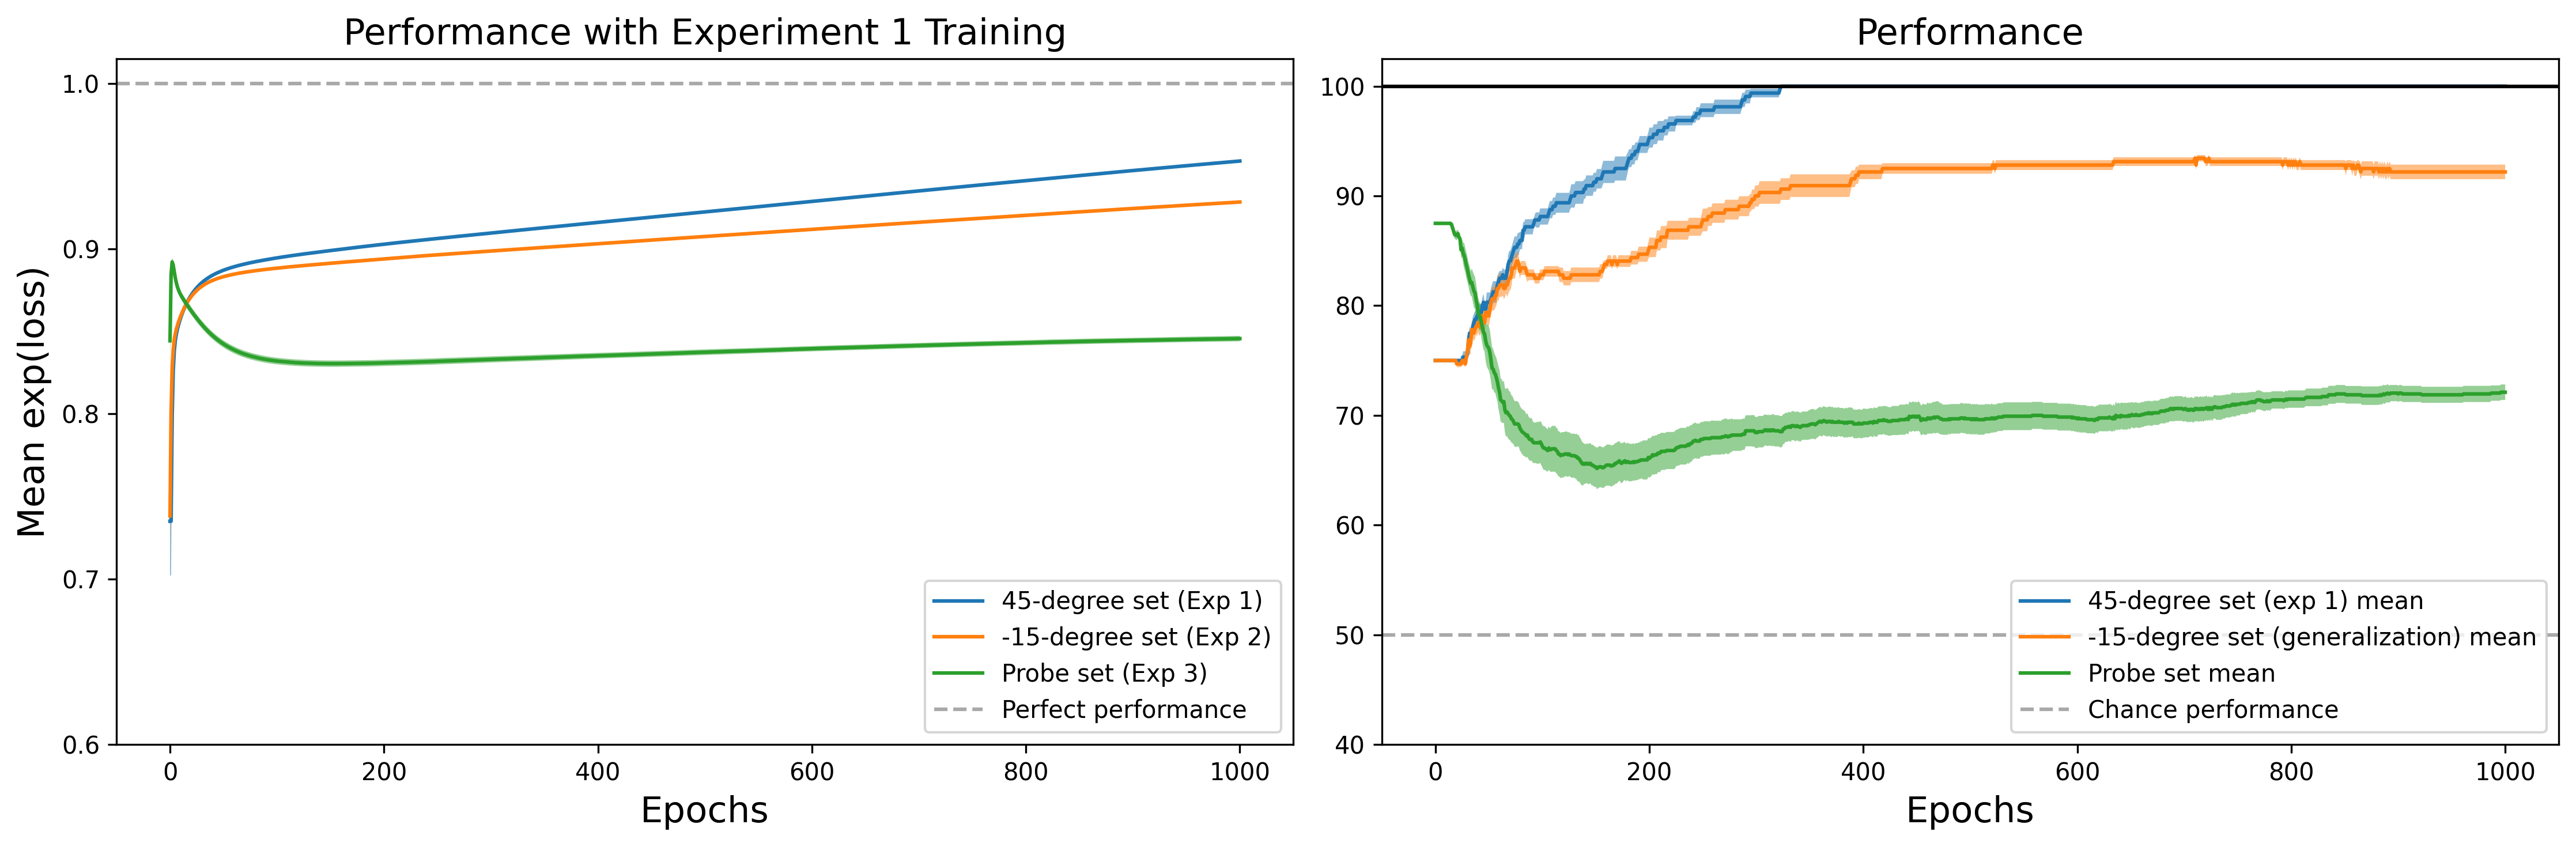

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), facecolor='w', edgecolor='k', dpi = 300)
ax[0].plot(train_losses_mean)
ax[0].plot(test_losses_mean)
ax[0].plot(probe_losses_mean)
ax[0].axhline(1, color = 'darkgray', ls = '--',)



ax[0].fill_between(range(num_epochs+1), train_losses_mean-train_losses_sem, train_losses_mean+train_losses_sem, alpha = 0.5)
ax[0].fill_between(range(num_epochs+1), test_losses_mean-test_losses_sem, test_losses_mean+test_losses_sem, alpha = 0.5)
ax[0].fill_between(range(num_epochs+1), probe_losses_mean-probe_losses_sem, probe_losses_mean+probe_losses_sem, alpha = 0.5)
# ax[0].axhline(0, color = 'k')
ax[0].set_title('Performance with Experiment 1 Training', fontsize = 15)
ax[0].legend(['45-degree set (Exp 1)', 
              '-15-degree set (Exp 2)',
              'Probe set (Exp 3)', 'Perfect performance'], loc='lower right')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_yticks(np.arange(0.6, 1.01, 0.1))
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Mean exp(loss)', fontsize = 15)


# ax[0].set_xticks(np.arange(0, 100.1, 10))
# ax[0].grid()


ax[1].plot(train_performance_mean)
ax[1].plot(test_performance_mean)
ax[1].plot(probe_performance_mean)
ax[1].axhline(50, color = 'darkgray', ls = '--', label = 'chance')

ax[1].fill_between(range(num_epochs+1), train_performance_mean-train_performance_sem, train_performance_mean+train_performance_sem, alpha = 0.5)
ax[1].fill_between(range(num_epochs+1), test_performance_mean-test_performance_sem, test_performance_mean+test_performance_sem, alpha = 0.5)
ax[1].fill_between(range(num_epochs+1), probe_performance_mean-probe_performance_sem, probe_performance_mean+probe_performance_sem, alpha = 0.5)
# ax[1].axhline(75, color = 'darkgray', ls = '--', label = 'chance')
# ax[1].fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')
ax[1].axhline(100, color = 'k')
ax[1].set_title('Performance', fontsize = 15)
ax[1].legend(['45-degree set (exp 1) mean', 
              '-15-degree set (generalization) mean', 
              'Probe set mean', 'Chance performance',], loc='lower right')
# ax[1].set_xticks(np.arange(0, 100.1, 10))
ax[1].set_yticks(np.arange(40, 100.1, 10))
ax[1].set_xlabel('Epochs', fontsize = 15)

# ax[1].grid()

fig.tight_layout()

# plt.savefig('/content/drive/MyDrive/rhesus_category_learning_model/Learning NN/output_plots/' + '.png', bbox_inches='tight')


array([0.73507966, 0.73507966, 0.79916089, ..., 0.95290383, 0.95295783,
       0.95301299])

Text(0, 0.5, 'Mean exp(loss)')

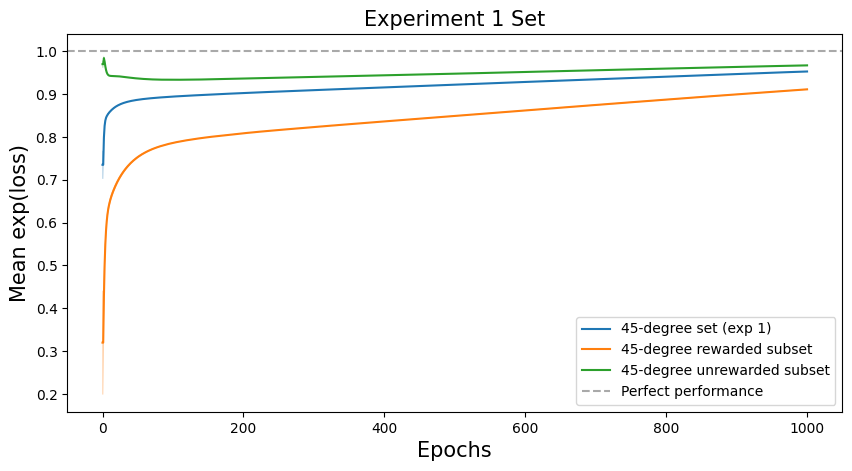

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_losses_mean)
ax.plot(train_loss_rewarded_mean)
ax.plot(train_loss_unrewarded_mean)
ax.axhline(1, color = 'darkgray', ls = '--')

display(train_losses_mean)

ax.fill_between(range(num_epochs+1), train_losses_mean-train_losses_sem, train_losses_mean+train_losses_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), train_loss_rewarded_mean-train_loss_rewarded_sem, train_loss_rewarded_mean+train_loss_rewarded_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), train_loss_unrewarded_mean-train_loss_unrewarded_sem, train_loss_unrewarded_mean+train_loss_unrewarded_sem, alpha = 0.5)

# ax.plot(test_performance_mean)
# ax.fill_between(range(num_epochs+1), test_performance_mean-test_performance_sem, test_performance_mean+test_performance_sem, alpha = 0.5)

# ax.plot(test_loss_rewarded_mean)
# ax.fill_between(range(num_epochs+1), test_loss_rewarded_mean-test_loss_rewarded_sem, test_loss_rewarded_mean+test_loss_rewarded_sem, alpha = 0.5)

# ax.plot(test_loss_unrewarded_mean)
# ax.fill_between(range(num_epochs+1), test_loss_unrewarded_mean-test_loss_unrewarded_sem, test_loss_unrewarded_mean+test_loss_unrewarded_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1)', '45-degree rewarded subset', '45-degree unrewarded subset', 'Perfect performance'], loc='lower right') #'45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
           #'45-degree rewarded subset mean', '45-degree rewarded subset SEM',

# ax.set_yticks(np.arange(0, 100.1, 10))
# ax.set_xlim(-1,600)
ax.set_title("Experiment 1 Set", fontsize = 15)
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel("Loss", fontsize = 15)
ax.set_ylabel('Mean exp(loss)', fontsize = 15)

# ax.grid()

# display(test_loss_unrewarded.shape)

Text(0, 0.5, 'Mean exp(loss)')

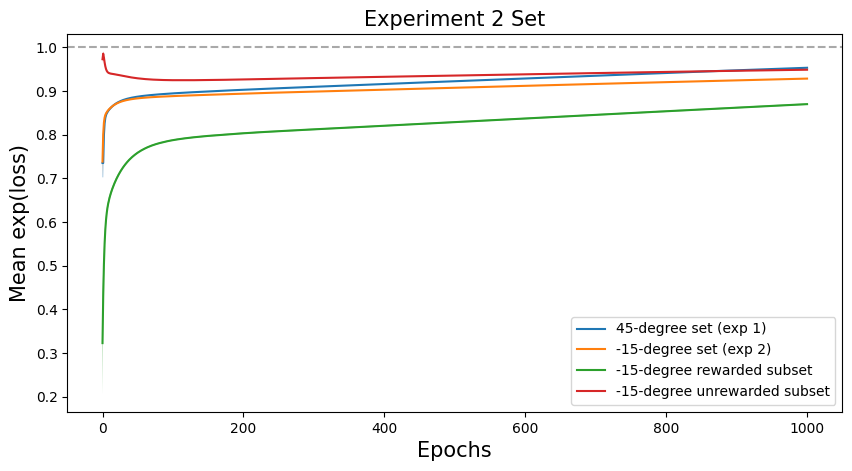

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_losses_mean)
ax.plot(test_losses_mean)
ax.plot(test_loss_rewarded_mean)
ax.plot(test_loss_unrewarded_mean)

ax.fill_between(range(num_epochs+1), train_losses_mean-train_losses_sem, train_losses_mean+train_losses_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_losses_mean-test_losses_sem, test_losses_mean+test_losses_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_loss_rewarded_mean-test_loss_rewarded_sem, test_loss_rewarded_mean+test_loss_rewarded_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_loss_unrewarded_mean-test_loss_unrewarded_sem, test_loss_unrewarded_mean+test_loss_unrewarded_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1)', 
           '-15-degree set (exp 2)', 
           '-15-degree rewarded subset', 
           '-15-degree unrewarded subset',
            ], loc='lower right') #'45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
           #'45-degree rewarded subset mean', '45-degree rewarded subset SEM',

# ax.set_yticks(np.arange(0, 100.1, 10))
# ax.set_ylim(0,105)
ax.axhline(1, color = 'darkgray', ls = '--')
ax.set_title("Experiment 2 Set", fontsize = 15)


ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel('Mean exp(loss)', fontsize = 15)

Text(0, 0.5, 'Mean exp(loss)')

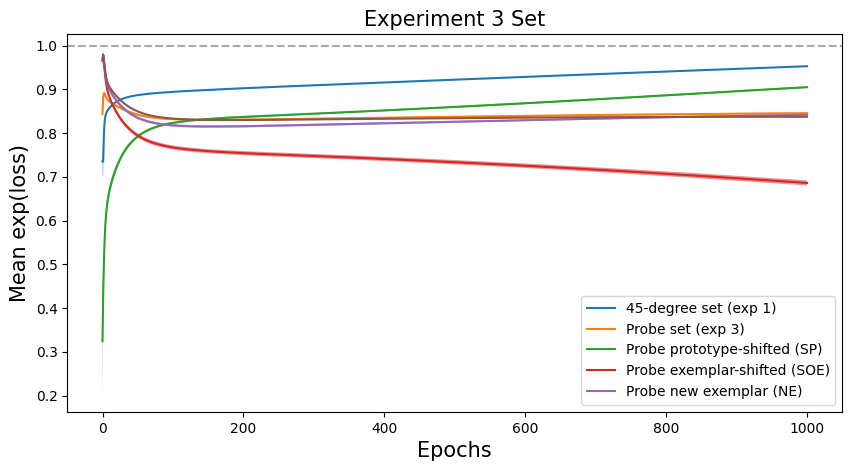

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_losses_mean)

ax.plot(probe_losses_mean)
ax.plot(probe_loss_rewarded_mean)
ax.plot(probe_loss_SOE_mean)
ax.plot(probe_loss_NE_mean)
ax.plot(probe_loss_unrewarded_mean)

ax.fill_between(range(num_epochs+1), train_losses_mean-train_losses_sem, train_losses_mean+train_losses_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_losses_mean-probe_losses_sem, probe_losses_mean+probe_losses_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_loss_rewarded_mean-probe_loss_rewarded_sem, probe_loss_rewarded_mean+probe_loss_rewarded_sem, alpha = 0.5)

ax.fill_between(range(num_epochs+1), probe_loss_SOE_mean-probe_loss_SOE_sem, probe_loss_SOE_mean+probe_loss_SOE_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_loss_NE_mean-probe_loss_NE_sem, probe_loss_NE_mean+probe_loss_NE_sem, alpha = 0.5)
# ax.fill_between(range(num_epochs+1), probe_loss_distractor_mean-probe_loss_distractor_sem, probe_loss_distractor_mean+probe_loss_distractor_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1)', 
           'Probe set (exp 3)',
           'Probe prototype-shifted (SP)',
           'Probe exemplar-shifted (SOE)',
           'Probe new exemplar (NE)',
            ], loc='lower right')

# ax.set_yticks(np.arange(0, 100.1, 10))
# ax.set_ylim(0,105)
# ax.grid()

ax.set_title("Experiment 3 Set", fontsize = 15)
ax.axhline(1, color = 'darkgray', ls = '--')
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel('Mean exp(loss)', fontsize = 15)


Text(0, 0.5, 'SP > SOE %')

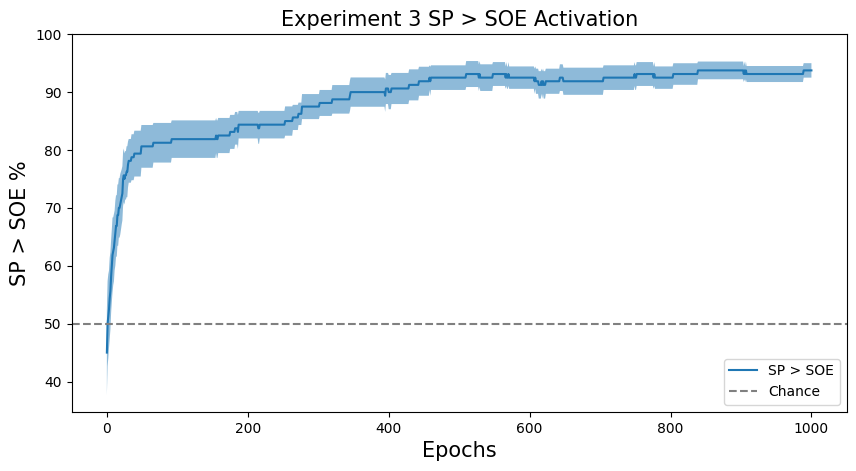

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(probe_loss_SP_over_SOE_performance_mean)
ax.axhline(50, color = 'gray', ls = '--')

ax.fill_between(range(num_epochs+1), probe_loss_SP_over_SOE_performance_mean-probe_loss_SP_over_SOE_performance_sem, probe_loss_SP_over_SOE_performance_mean+probe_loss_SP_over_SOE_performance_sem, alpha = 0.5)


# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['SP > SOE', 
           'Chance',
            ], loc = 'lower right')

ax.set_yticks(np.arange(40, 100.1, 10))
# ax.set_ylim(0,105)
# ax.grid()

ax.set_title("Experiment 3 SP > SOE Activation", fontsize = 15)
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel('SP > SOE %', fontsize = 15)


In [ ]:
hidden_acts = hidden_acts.reshape(-1, 100)

display(hidden_acts.shape)

trials = []
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_L')
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_R')

hidden_acts_df = pd.DataFrame(data = hidden_acts)

hidden_acts_df['Trial'] = np.array(trials * (num_epochs+1) * num_runs)
hidden_acts_df['Run'] = np.repeat(range(0, num_runs), 32 * (num_epochs+1))
hidden_acts_df['Epoch'] = np.tile(np.repeat(range(0, num_epochs+1), 32),num_runs)

# display(hidden_acts_df.iloc[31950:32050])

def gen_heatmap(df,epc, ca1_size):

    runsnum = (pd.to_numeric(df['Run']).max()) + 1
    df_epc = df[df["Epoch"] == epc]

    ca1avgrep = pd.DataFrame()

    trials = []
    for i in range(1, 5):
      for j in range(1, 5):
        trials.append(f'F{i}_{j}_45_L')
    for i in range(1, 5):
      for j in range(1, 5):
        trials.append(f'F{i}_{j}_45_R')

    for run in range(runsnum):
        df_epc_run = df_epc[df_epc["Run"] == run]

        ca1acts = df_epc_run.iloc[:, 0:ca1_size]
        # display(ca1acts.shape)
        ca1acts = ca1acts.transpose()
        # display(ca1acts.shape)
        ca1acts = ca1acts.astype(float)
        ca1acts.columns = trials
        ca1actscorr = ca1acts.corr()
        # display(ca1actscorr.shape)
        ca1avgrep = pd.concat([ca1avgrep, ca1actscorr])
    
    
    # display(ca1avgrep)
    ca1avgrep = ca1avgrep.groupby(ca1avgrep.index, sort = False).mean()
    ca1semrep = ca1avgrep.groupby(ca1avgrep.index, sort = False).sem()

    # display(ca1avgrep)
        
    np.fill_diagonal(ca1avgrep.values, np.nan)
    
    return ca1avgrep, ca1semrep

(320320, 100)

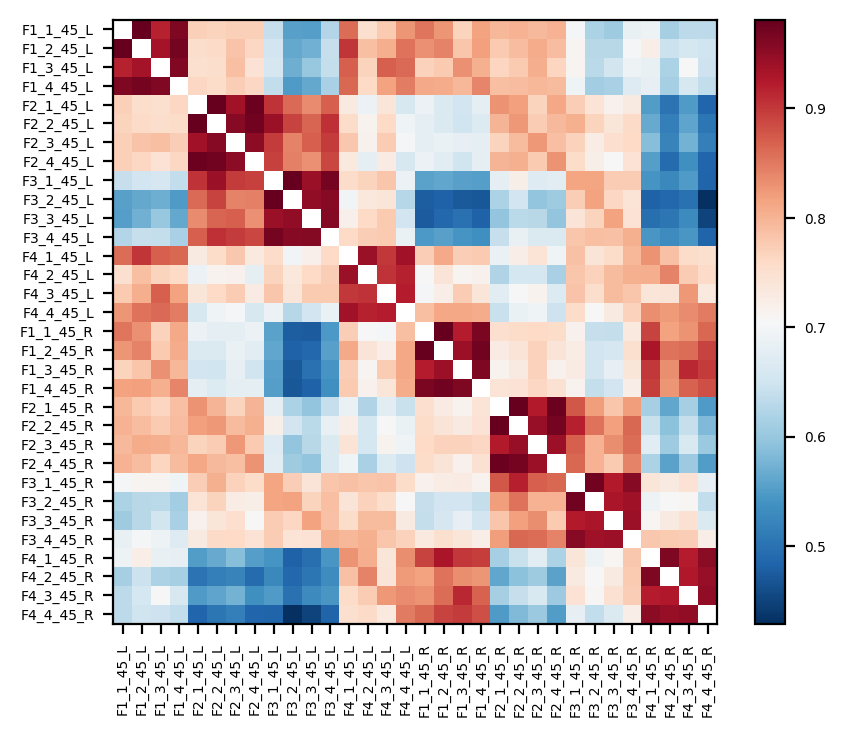

In [ ]:
trials = []
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_L')
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_R')


plt.figure(dpi=200)
heatmap_epc = 1000
plt.imshow(gen_heatmap(hidden_acts_df, heatmap_epc, 100)[0], cmap = 'RdBu_r')
plt.xticks([*np.arange(-0,32)], trials, rotation = 90, fontsize = 5)
plt.yticks([*np.arange(-0,32)], trials, fontsize = 5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=5) 
fig = plt.gcf()
plt.show()

In [ ]:
trials = []
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_L')
for i in range(1, 5):
  for j in range(1, 5):
    trials.append(f'F{i}_{j}_45_R')


trials

['F1_1_45_L',
 'F1_2_45_L',
 'F1_3_45_L',
 'F1_4_45_L',
 'F2_1_45_L',
 'F2_2_45_L',
 'F2_3_45_L',
 'F2_4_45_L',
 'F3_1_45_L',
 'F3_2_45_L',
 'F3_3_45_L',
 'F3_4_45_L',
 'F4_1_45_L',
 'F4_2_45_L',
 'F4_3_45_L',
 'F4_4_45_L',
 'F1_1_45_R',
 'F1_2_45_R',
 'F1_3_45_R',
 'F1_4_45_R',
 'F2_1_45_R',
 'F2_2_45_R',
 'F2_3_45_R',
 'F2_4_45_R',
 'F3_1_45_R',
 'F3_2_45_R',
 'F3_3_45_R',
 'F3_4_45_R',
 'F4_1_45_R',
 'F4_2_45_R',
 'F4_3_45_R',
 'F4_4_45_R']

In [ ]:
# ## TSP

# class TSP(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size, sparsity):
#       super(TSP, self).__init__()
#       self.input_size = input_size
#       self.hidden_size = hidden_size
#       self.output_size = output_size
#       self.sparsity = sparsity


#       # initialize weight matrix with zeros
#       self.w1 = nn.Parameter(torch.zeros(hidden_size, input_size))
#       self.w2 = nn.Parameter(torch.zeros(output_size, hidden_size))

#       # create a mask with the same shape as the weight matrix
#       self.mask1 = torch.ones(hidden_size, input_size)
#       self.mask2 = torch.ones(output_size, hidden_size)

#       # set random elements of the mask to zero according to the sparsity
#       num_zeros1 = int(sparsity * hidden_size * input_size)
#       num_zeros2 = int(sparsity * output_size * hidden_size)
#       indices1 = torch.randperm(hidden_size * input_size)[:num_zeros1]
#       indices2 = torch.randperm(output_size * hidden_size)[:num_zeros2]
#       self.mask1.view(-1)[indices1] = 0
#       self.mask2.view(-1)[indices2] = 0

#       # register the mask as a buffer so it is not updated during training
#       self.register_buffer('mask1', self.mask1)
#       self.register_buffer('mask2', self.mask2)

#       self.relu = nn.ReLU()
#       self.sigmoid = nn.Sigmoid()

#   def forward(self, x):
#       x = torch.mm(x, self.w1 * self.mask1.T)
#       x = self.relu(x)
#       x = torch.mm(x, self.w2 * self.mask2.T)
#       x = self.sigmoid(x)
#       return x


# class SparseLinear(nn.Module):
#   def __init__(self, in_features, out_features, sparse_indices):
#     super(SparseLinear, self).__init__()
#     self.weight = nn.Parameter(data=torch.sparse.FloatTensor(sparse_indices, torch.randn(sparse_indices.shape[1]), [in_features, out_features]), requires_grad=True)
#     self.bias = nn.Parameter(data=torch.randn(out_features), requires_grad=True)



In [ ]:
# # create train and test datasets and dataloaders
# labels = np.concatenate([np.repeat(1,4), np.repeat(0,16), np.repeat(1,4), np.repeat(0,8), 
#                          np.repeat(0,4), np.repeat(1,16), np.repeat(0,4), np.repeat(1,8)])

# tsp_train_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/train_vgg-16_embeddings.csv', labels)
# tsp_train_dataloader = DataLoader(tsp_train_dataset, batch_size=32, shuffle=True)
# tsp_test_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/train_vgg-16_embeddings_generalization.csv', labels)
# tsp_test_dataloader = DataLoader(tsp_test_dataset, batch_size=32)

# # set up the model, loss function, and optimizer
# model = TSP(4196, 100, 2, 0.9)
# criterion = nn.MSELoss() # nn.BCEWithLogitsLoss() if we switch to one unit output (binary)
# optimizer = optim.SGD(model.parameters(), lr=0.01) # torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# # define sparse matrix
# indices = [[0, 1, 1, 2], [0, 1, 3, 4]]
# values = [1, 2, 3, 4]
# shape = [5, 3]
# sparse_matrix = torch.sparse_coo_tensor(indices, values, shape)

# sparse_matrix

In [ ]:
rewarded_labels = np.zeros(32)
rewarded_labels[2::4] = 1
rewarded_labels = np.concatenate([rewarded_labels, np.zeros(64), rewarded_labels])

[rewarded_labels == False]

[array([ True,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,
      